# Analysis of Strang-carryover with RK3 for AdImEx Advection
## Plan
- Discretise the advection equation in space using quasi-cubic
- Aapply Strang-carryover adaptively implicitly (AdImEx) with high-order corrections treated explicitly.
- Analyse the stabiltiy of the Strang-carryover scheme

## Discretisation of the Advection Equation
\begin{eqnarray}
\frac{\partial \psi}{\partial t} &=& -u \frac{\partial \psi}{\partial x} \\
\text{Assume } \psi_j &=& e^{ikj\Delta x},\ c = u\Delta t/\Delta x,\ \lambda = u/\Delta x \\
\end{eqnarray}
\begin{eqnarray}
\text{Analytic } \frac{dy}{dt} &=& - i\lambda k\Delta x y \\
\end{eqnarray}
The spatially discretised advection equation can be written as a correction on upwind:
\begin{eqnarray}
\frac{dy}{dt} &=& -\lambda(\mu  + \eta) y\\
\text{where } \mu &=& 1-\cos k\Delta x + i\sin k\Delta x \ \text{ (upwind)}\\
\text{and }   \eta &=& -\mu + \left\{
\sum_\ell w_\ell\  e^{i\ell k\Delta x} - \sum_{\ell-1} w_\ell\  e^{i\ell k\Delta x}
\right\}  \ \text{ (correction)}
\end{eqnarray}

The correction weights for a more general, higher-order discretisation of $\frac{\partial \psi}{\partial x}$:
\begin{eqnarray}
\frac{\partial \psi}{\partial x}_{HOj} &=& \frac{\psi_{j+1/2} - \psi_{j-1/2}}{\Delta x} \\
\text{where } \psi_{j+1/2} &=& \sum_{j+\ell} w_\ell\ \psi_{j+\ell}\\
\implies
\frac{\partial \psi}{\partial x}_{HOj} &=& \sum_{j+\ell} \frac{w_\ell\ \psi_{j+\ell}}{\Delta x}
                                    - \sum_{j+\ell-1} \frac{w_\ell\ \psi_{j+\ell}}{\Delta x}\\
\implies -u\frac{\partial \psi}{\partial x}_{HOj} &=& -\psi_j \lambda \left\{
\sum_\ell w_\ell\  e^{i\ell k\Delta x} - \sum_{\ell-1} w_\ell\  e^{i\ell k\Delta x}
\right\}
\end{eqnarray}


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
#import fluidfoam as foam
from sympy import latex
from sympy import I, E, pi, Q

In [3]:
# mu and eta for quasi-cubic
kDx = sy.symbols("kΔx", real=True)
mu = 1 - E**(-I*kDx)
eta = -mu

indicies = [-1,0,1]
weights = [sy.Rational(-1,6), sy.Rational(5,6), sy.Rational(1,3)]
for j,w in zip(indicies, weights):
    eta += w*(E**(j*I*kDx) - E**((j-1)*I*kDx))

#print(mu.subs({kDx: pi/3}).evalf())
#print(eta.subs({kDx: pi/3}).evalf())
eta

exp(I*kΔx)/3 - 1/2 + exp(-2*I*kΔx)/6

In [4]:
# RK3 Butcher Tableau
quarter = sy.Rational(1,4)
sixth = sy.Rational(1,6)
RK3 = [[1,0,0], [quarter,quarter,0], [sixth, sixth, 4*sixth]]
RK1 = [[1]]
RK = RK3

In [5]:
# Amplification factors with symbolic Python
c, alpha, beta, gamma = sy.symbols("c, alpha, beta, gamma", real=True, positive=True)
A = sy.Matrix(sy.symarray("A", (len(RK)+2,)))
A[0] = 1 - c*(1-alpha)*beta*mu
for i in range(1,len(RK)+1):
    A[i] = A[0]
    for j in range(0,i):
        A[i] -= c*((1-beta)*mu + gamma*eta)*RK[i-1][j]*A[j]
A[-1] = A[-2]/(1 + c*alpha*beta*mu)

Aab = A[-1].subs({alpha: 1-1/c, beta: 1-1/c, kDx: pi/2})
Aab = sy.refine(Aab, Q.positive(c-2))
Aab = sy.refine(Aab, Q.positive(gamma))
Aab = sy.refine(Aab, Q.positive(1-gamma))
g = sy.solve(sy.re(Aab)**2 + sy.im(Aab)**2 -1, gamma)
magSqrA = sy.collect(sy.re(Aab)**2 + sy.im(Aab)**2, c)
magSqrA = sy.simplify(magSqrA)
magSqrA

(125*c**6*gamma**6 + 450*c**5*gamma**5 + 2025*c**4*gamma**4 + 1404*c**3*gamma**3 - 972*c**2*gamma**2 + 5832)/(26244*(2*c**2 - 2*c + 1))

In [23]:
# Amplification factor for alpha=0.5, beta=1
Ai = A[-1].subs({alpha: sy.Rational(1,2), beta: 1, kDx: pi/2})
Ai = sy.refine(Ai, Q.positive(c-2))
Ai = sy.refine(Ai, Q.positive(gamma))
Ai = sy.refine(Ai, Q.positive(1-gamma))
gi = sy.solve(sy.re(Ai)**2 + sy.im(Ai)**2 -1, gamma)
magSqrAi = sy.collect(sy.re(Ai)**2 + sy.im(Ai)**2, c)
magSqrAi = sy.simplify(magSqrAi)
magSqrAi

(125*c**8*gamma**6 - 250*c**7*gamma**6 + 900*c**7*gamma**5 + 250*c**6*gamma**6 - 1800*c**6*gamma**5 + 3645*c**6*gamma**4 + 1800*c**5*gamma**5 - 7290*c**5*gamma**4 + 10368*c**5*gamma**3 + 7290*c**4*gamma**4 - 20736*c**4*gamma**3 + 23328*c**4*gamma**2 + 20736*c**3*gamma**3 - 46656*c**3*gamma**2 + 34992*c**3*gamma + 46656*c**2*gamma**2 - 69984*c**2*gamma + 26244*c**2 + 69984*c*gamma - 52488*c + 52488)/(26244*(c**2 + 2*c + 2))

In [6]:
def magA(cs, gs):
    try:
        cs, gs = np.meshgrid(cs, gs)
    except:
        pass
    return sy.lambdify([c, gamma], magSqrA**.5, 'numpy')(cs, gs)

cs = np.linspace(2, 20, 36)
gs = np.linspace(0, 1, 11)
Ag = magA(cs, gs)

In [7]:
g = sy.solve(magSqrA -1, gamma)
print(g)

# Print solutions using magSqrA and magA
for ga in g:
    ga = sy.simplify(ga)
    ga = sy.collect(ga, c)
    ga = sy.simplify(ga)
    print('Solution :', ga)
    Co = 20
    Ga = ga.subs({c: Co})
    if sy.im(Ga) == 0:
        if Ga > 0. and Ga < 1.:
            print('gamma =', Ga.evalf(), 'c =', Co, 'magSqrA =', magSqrA.subs({gamma: Ga, c: Co}).evalf(),
                  'magA =', magA(Co, Ga.evalf()))
            print('g(c) = ',ga)
            gByc = sy.lambdify(c, ga, 'numpy')

[]


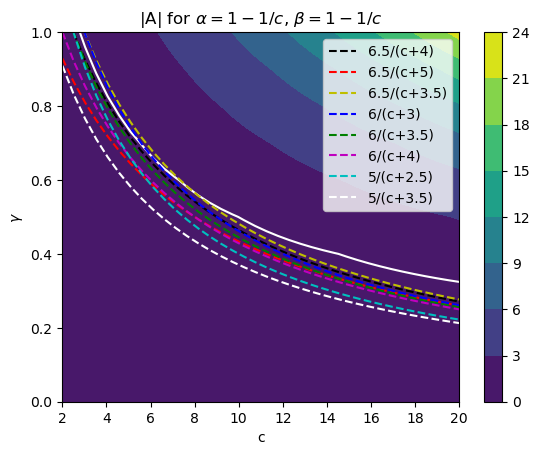

In [17]:
plt.contourf(cs, gs, Ag)
plt.colorbar()
plt.contour(cs, gs, Ag, [1,100], colors='w')
plt.plot(cs, 6.5/np.maximum(1, cs+4), 'k--', label='6.5/(c+4)')
plt.plot(cs, 6.5/np.maximum(1, cs+5), 'r--', label='6.5/(c+5)')
plt.plot(cs, 6.5/np.maximum(1, cs+3.5), 'y--', label='6.5/(c+3.5)')
plt.plot(cs, 6/np.maximum(1, cs+3), 'b--', label='6/(c+3)')
plt.plot(cs, 6/np.maximum(1, cs+3.5), 'g--', label='6/(c+3.5)')
plt.plot(cs, 6/np.maximum(1, cs+4), 'm--', label='6/(c+4)')
plt.plot(cs, 5/np.maximum(1, cs+2.5), 'c--', label='5/(c+2.5)')
plt.plot(cs, 5/np.maximum(1, cs+3.5), 'w--', label='5/(c+3.5)')
#plt.plot(cs, gByc(cs), label='gByc')
plt.legend()
plt.xlabel('c')
plt.ylabel(r'$\gamma$')
plt.ylim([0,1])
plt.title(r'|A| for $\alpha=1-1/c$, $\beta=1-1/c$')
plt.savefig('plots/AadImExgamma.pdf')
plt.show()